In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from azureml.core import Dataset
from azureml.data import tabular_dataset
from azureml.core import Workspace, Dataset
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.filters import threshold_otsu
import cv2

In [2]:
#Wczytanie danych
subscription_id = #your data
resource_group = #your data
workspace_name = #your data
# or other way to load the data

workspace = Workspace(subscription_id, resource_group, workspace_name)

mnist = Dataset.get_by_name(workspace, name='MNIST')
mnist = mnist.to_pandas_dataframe()

In [3]:
mnist.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [3]:
#Funkcja opisująca podstawowe parametry danych
wystapienia = []
def opisz(mnist_dane):
    print('Liczba obiektów: \t' , len(mnist_dane.count(1)))
    print('Liczba atrybutów:\t' , len(mnist_dane.count(0)))
    label = mnist_dane['label']
    print('Liczba klas:\t\t', len(label.unique()))
    print('\n\nNazwy klas które występują: ' , np.sort(label.unique()))
    print('\nCzęstotliwość występowania każdej z klas: ')
    for i in np.sort(label.unique()):
        wystapienia.append(mnist_dane.groupby('label').size().loc[i])
        print('Klasa o nazwie: ' , i , ' ilość wystąpień: ', mnist_dane.groupby('label').size().loc[i])
    print('\n')
    print(mnist_dane.groupby('label').size().describe())
    print('\n')
    ilosc_brakow_danych = mnist_dane.isna().sum().sum()
    print('Ilość braków w danych wynosi:\t', ilosc_brakow_danych)
    mnist_dane.info()
    mnist_dane.describe()

In [4]:
opisz(mnist)

Liczba obiektów: 	 70000
Liczba atrybutów:	 785
Liczba klas:		 10


Nazwy klas które występują:  [0 1 2 3 4 5 6 7 8 9]

Częstotliwość występowania każdej z klas: 
Klasa o nazwie:  0  ilość wystąpień:  6903
Klasa o nazwie:  1  ilość wystąpień:  7877
Klasa o nazwie:  2  ilość wystąpień:  6990
Klasa o nazwie:  3  ilość wystąpień:  7141
Klasa o nazwie:  4  ilość wystąpień:  6824
Klasa o nazwie:  5  ilość wystąpień:  6313
Klasa o nazwie:  6  ilość wystąpień:  6876
Klasa o nazwie:  7  ilość wystąpień:  7293
Klasa o nazwie:  8  ilość wystąpień:  6825
Klasa o nazwie:  9  ilość wystąpień:  6958


count      10.000000
mean     7000.000000
std       399.315804
min      6313.000000
25%      6837.750000
50%      6930.500000
75%      7103.250000
max      7877.000000
dtype: float64


Ilość braków w danych wynosi:	 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, 0 to label
dtypes: int64(785)
memory usage: 419.2 MB


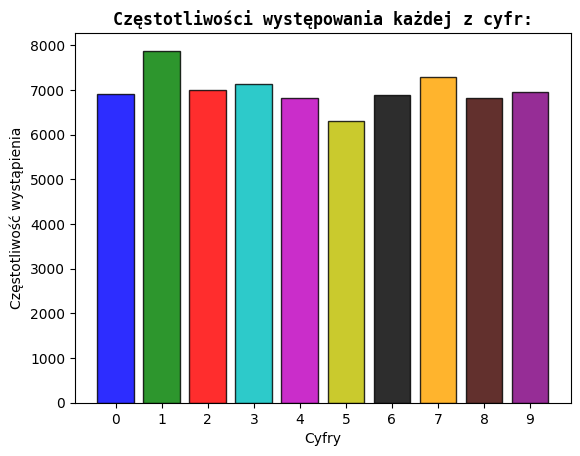

In [5]:
#Wizualizacja częstotliwości występowania każdej z klas tj. każdej z cyfr
numbers = np.sort(mnist['label'].unique())
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#ffa400', '#400400', '#800080']
plt.bar(numbers, wystapienia, color=colors,alpha=0.825,edgecolor='black')
plt.title('Częstotliwości występowania każdej z cyfr:',fontweight='bold',family='monospace')
plt.xlabel('Cyfry')
plt.ylabel('Częstotliwość wystąpienia')
plt.xticks(numbers)
plt.show()

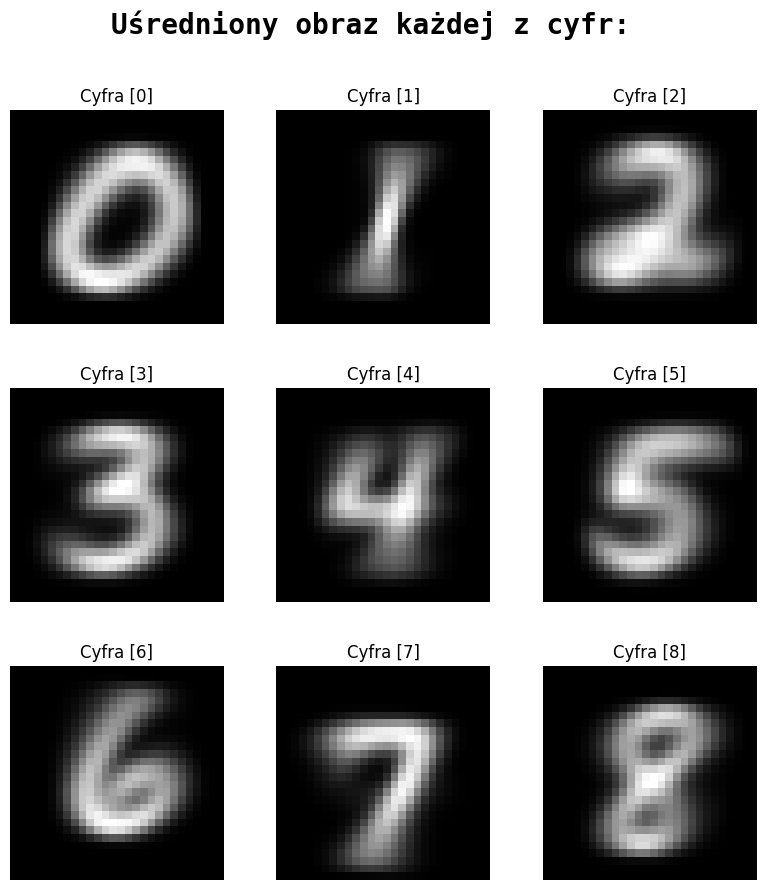

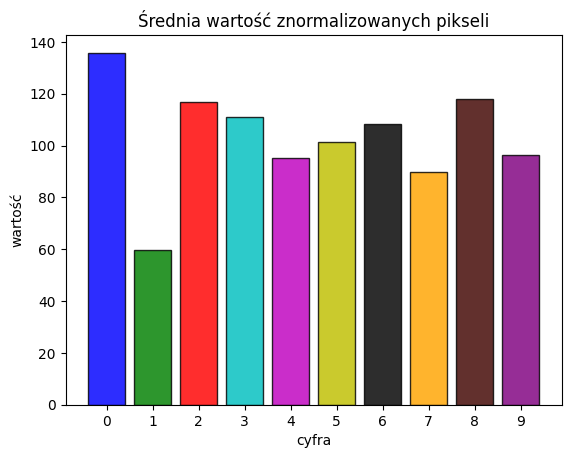

In [6]:
#Uśredniony obraz każdej z cyfr:
grupowanie = mnist.groupby('label')
srednia_atry = grupowanie.mean()
fig, axs = plt.subplots(3, 3,figsize=(10,10))
for i in range(3):
    for j in range(3):  
        grid = np.array(srednia_atry.iloc[i+3*j,:]).reshape(28,28)
        axs[j,i].imshow(grid, interpolation = "none",cmap = "gray")
        axs[j,i].set_title('Cyfra ['+str(i+3*j)+']')
        axs[j,i].axis('off')
plt.suptitle('Uśredniony obraz każdej z cyfr:',fontweight='bold',fontsize = 20,family='monospace')
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()


kopia = mnist.copy()
kopia = mnist.iloc[:,:-1]/255
kopia['label'] = mnist['label']
grupowane = kopia.groupby('label')
wynik = grupowane.mean()
wynik = wynik.sum(axis=1)
cyfry = range(0, len(wynik))
kolory = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#ffa400', '#400400', '#800080']
plt.bar(cyfry, wynik,color=kolory,alpha=0.825,edgecolor='black')
plt.xlabel('cyfra')
plt.ylabel('wartość')
plt.title('Średnia wartość znormalizowanych pikseli')
plt.xticks(cyfry)
plt.show()

In [7]:
#Rozdzielczość obrazów w badanym zbiorze
height = 28
width = 28

#Funkcja pozwalająca wyświetlić wybrane obrazy z zbioru danych mnist
def pokaz_obraz_mnist(ile_obrazow, lista_indeksow, mnist_dane):
    if ile_obrazow < 0 or not bool(lista_indeksow) or mnist_dane.empty:
        return print("Nie mozna wykonac funkcji: pokaz_obraz_mnist")
    fig, axs = plt.subplots(1, ile_obrazow, figsize=(18,5))
    for i in range(ile_obrazow):
        grid = np.array(mnist_dane.iloc[lista_indeksow[i],:-1]).reshape(height,width)
        axs[i].imshow(grid, interpolation = "none",cmap = "gray")
        axs[i].set_title('Index ['+str(lista_indeksow[i])+'], Value ['+str(mnist_dane['label'].iloc[lista_indeksow[i]])+']')
        axs[i].axis('off')
    plt.suptitle('Losowo wybrane obrazy:',fontweight='bold',fontsize = 20,family='monospace')
    plt.show()


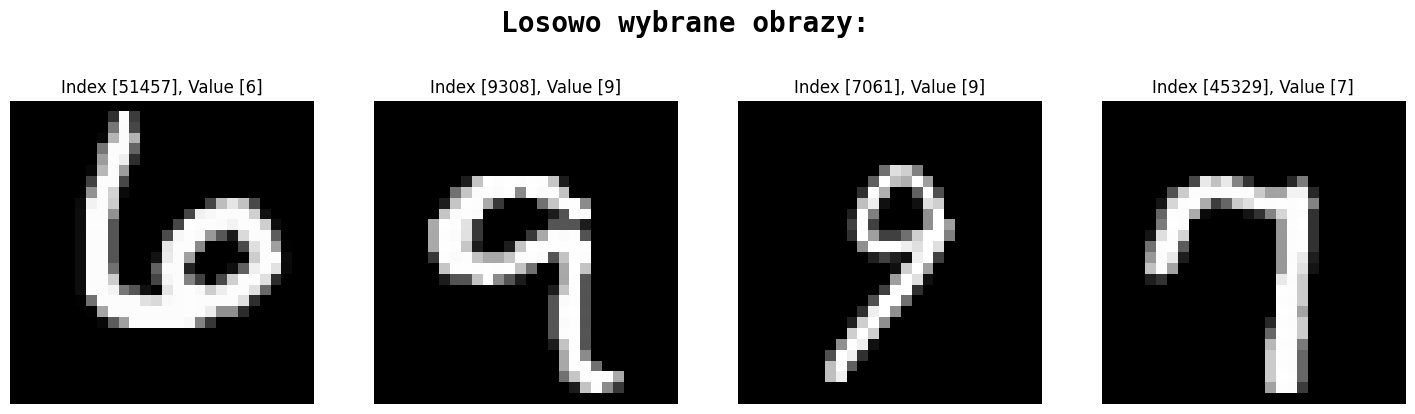

In [8]:
#Przykładowe obrazy z zestawu danych MNIST
idx_1,idx_2,idx_3,idx_4 = random.sample(range(70000), 4)
lista_indeksow = (idx_1,idx_2,idx_3,idx_4)
pokaz_obraz_mnist(4,lista_indeksow,mnist)

In [9]:
#Redukcja danych do testów - użyć w razie potrzeby
mnist_zredukowane = mnist[0:5000]

In [20]:
#Cały zbiór danych
mnist_zredukowane = mnist

In [10]:
poczatkowo = len(mnist_zredukowane.count(0))


#   Redukcja wysoko skorelowanych atrybutów


#Utworzenie macierzy korelacji
cor_matrix = mnist_zredukowane.drop(columns='label').corr().abs()

#Odnalezienie i usunięcie atrybutów wysoko skorelowanych
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(abs(upper_tri[column] > 0.9))]
skorelowane = len(to_drop)
print('Ilosc cech do usuniecia: ', skorelowane)
to_drop = list(map(int, to_drop))
mnist_zredukowane = mnist_zredukowane.drop(mnist_zredukowane.columns[[to_drop]], axis=1)


#   Usunięcie atrybutów z samymi zerami


#Utworzenie informacji na bazie których dokonana zostanie redukcja
stats = mnist_zredukowane[:-1].describe().T

#Utworzenie maski umożliwiającej usunięcie kolumn w których nie występują inne wartości niż zero
maska = (stats['min'] == 0) & (stats['max'] == 0)
zera = len(stats[maska].index)
print('Ilosc cech pustych: ', zera)

#Usunięcie zbędnych atrybutów
mnist_zredukowane = mnist_zredukowane.drop(stats[maska].index, axis=1)
koncowo = len(mnist_zredukowane.count(0))

opisz(mnist_zredukowane)
mnist_zredukowane


Ilosc cech do usuniecia:  13
Ilosc cech pustych:  111
Liczba obiektów: 	 10000
Liczba atrybutów:	 661
Liczba klas:		 10


Nazwy klas które występują:  [0 1 2 3 4 5 6 7 8 9]

Częstotliwość występowania każdej z klas: 
Klasa o nazwie:  0  ilość wystąpień:  1001
Klasa o nazwie:  1  ilość wystąpień:  1127
Klasa o nazwie:  2  ilość wystąpień:  991
Klasa o nazwie:  3  ilość wystąpień:  1032
Klasa o nazwie:  4  ilość wystąpień:  980
Klasa o nazwie:  5  ilość wystąpień:  863
Klasa o nazwie:  6  ilość wystąpień:  1014
Klasa o nazwie:  7  ilość wystąpień:  1070
Klasa o nazwie:  8  ilość wystąpień:  944
Klasa o nazwie:  9  ilość wystąpień:  978


count      10.000000
mean     1000.000000
std        70.804896
min       863.000000
25%       978.500000
50%       996.000000
75%      1027.500000
max      1127.000000
dtype: float64


Ilość braków w danych wynosi:	 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 661 entries, 35 to label
dtypes: int64(661)
memory usa

,35,38,39,40,41,42,43,44,45,46,...,770,771,772,773,774,775,776,777,778,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


                                                              Wpływa konkretnych działań na ilość atrybutów                                                                              

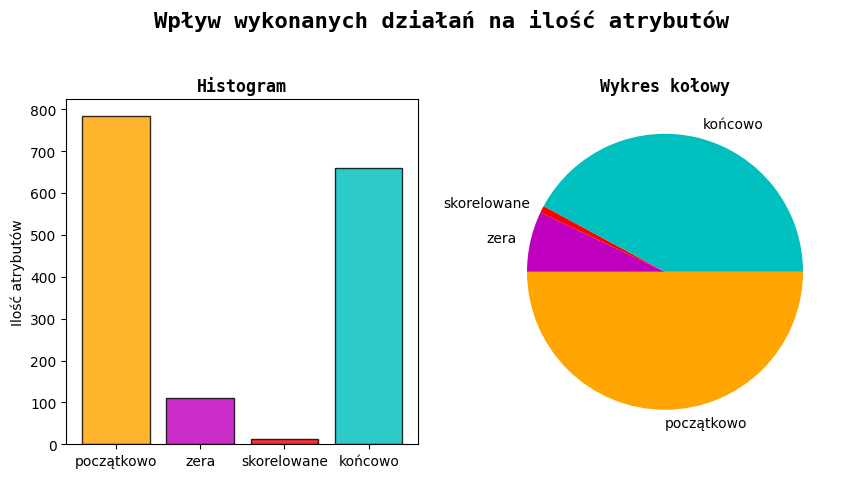

In [11]:
#Zobrazowanie ilości usunietych atrybutów
info = ('początkowo','zera', 'skorelowane','końcowo')
wystapienia = (poczatkowo,zera,skorelowane,koncowo)
colors = ['#ffa400', 'm', 'r','c']
fig, ax = plt.subplots(figsize=(10, 5))
plt.suptitle('Wpływ wykonanych działań na ilość atrybutów',fontweight='bold',family='monospace',fontsize = 16)
plt.subplot(1,2,1)
plt.bar(info, wystapienia, color=colors,alpha=0.825,edgecolor='black')
plt.title('Histogram',fontweight='bold',family='monospace')
plt.ylabel('Ilość atrybutów')
plt.subplot(1,2,2)
plt.title('Wykres kołowy',fontweight='bold',family='monospace')
plt.pie(wystapienia,colors=colors,counterclock=False,labels=info)
plt.subplots_adjust(top=0.8)
plt.show()



                                                t-SNE - wizualizacja wysokowymiarowych danych

**t-SNE **(t-Distributed Stochastic Neighbor Embedding) - to metoda redukcji wymiarowości, 
która jest używana do wizualizacji danych wysokowymiarowych. Jest szczególnie przydatna
do wizualizacji zestawów danych z wieloma cechami lub zestawów danych,
które nie są łatwo wizualizowane za pomocą tradycyjnych technik

  **Zasada działania**   
Algorytm t-SNE działa przez mapowanie punktów danych wysokowymiarowych na
przestrzeń niższej wymiarowości (zazwyczaj 2D lub 3D) przy jednoczesnym zachowaniu
dystansów pomiędzy punktami danych jak najlepiej. Używa rozkładu prawdopodobieństwa 
do mierzenia podobieństwa między punktami danych w przestrzeni wysokowymiarowej, 
a następnie tworzy rozkład prawdopodobieństwa w przestrzeni niższej wymiarowości,
który najlepiej odpowiada rozkładowi wysokowymiarowemu.

In [13]:
#Wizualizacja grupowania się cyfr w klastr
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(mnist_zredukowane)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mnist_zredukowane['label'], cmap='rainbow')
plt.suptitle('Wizualizacja grupowania się cyfr w klastr',fontweight='bold',family='monospace')
plt.axis('off')
plt.colorbar()
plt.show()

#30min brak efektu ;p

                                                                     Wstępne wnioski:

Zestaw danych:

Używany w analizie zestaw danych MNIST posiada 70'000 obiektów oraz 785 atrybutów, wszystkie z nich reprezentowane są jako liczby całkowite typu int64.
Pierwsze 784 atrybuty to atrybuty opisujące odwzorowują każdy piksel z danego obrazu w skali szarości, w zakresie od 0 do 255.
Wartość 0 oznacza czarny piksel, natomiast 255 oznacza całkowitą biel. 
Ostatnia kolumna to atrybut decyzyjny, przyporządkowuje on reprezentacji odręcznie pisanej liczby jej rzeczywiste odwzorowanie w postaci jednej z dziesięciu cyfr.
Badany zbiór mieści średnio 7000 każdej z cyfr z odchyleniem standardowym nie przekraczającym 6%. Żadna z klas nie dominuje w znaczącym stopniu całego kompletu danych.

Używany w analizie zbiór nie zawiera braków danych.



In [10]:
#Podzielenie danych na testowe i treningowe w stosunku 1:6

#Normalizacja
#Zredukowanie wartości do liczb z zakresu 0-1
from sklearn import model_selection
X = mnist_zredukowane.iloc[:,:-1]/255
y = mnist_zredukowane.iloc[:,-1:]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.167, random_state=0)

Text(0, 0.5, 'Prawdopodobienstwo bledu')

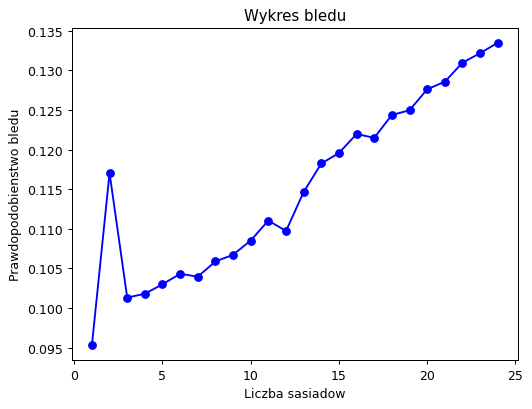

In [7]:
#METODA K-NN
#Analiza błędy klasyfikacji - dobranie ilości sąsiadów do metody k - najbliższych sąsiadów
data = np.zeros(24)
zakres = [x for x in range(1,25)]
for k in zakres:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_test, y_test.values.ravel())
    predictions = model.predict(X_train)
    data[k-1] = 1-model.score(X_train, y_train)
plt.figure(dpi=90)
plt.plot(zakres, data, '-bo')
plt.title('Wykres bledu')
plt.xlabel('Liczba sasiadow')
plt.ylabel('Prawdopodobienstwo bledu')

Czas uczenia:  1.0442264080047607


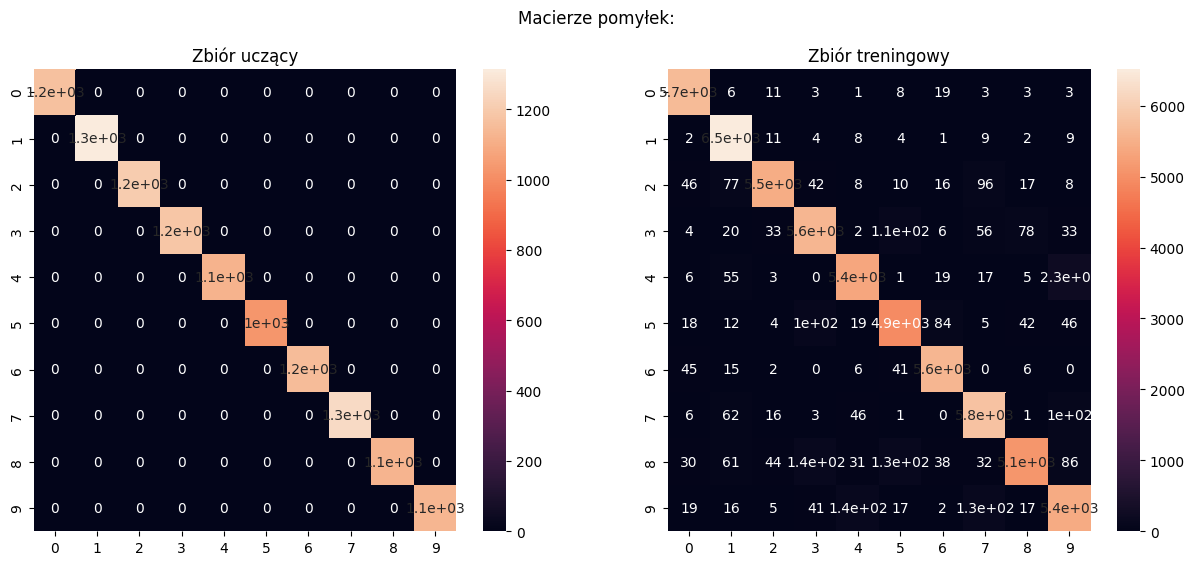

In [23]:
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_test, y_test.values.ravel())
end_time = time.time()
print("Czas uczenia: ", end_time - start_time)
wynik_ucz = knn.predict(X_test)
wynik_test = knn.predict(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Macierze pomyłek:')

#Macierz pomyłek dla zbioru do uczenia
mp = confusion_matrix(y_test, wynik_ucz)
ax1.set_title('Zbiór uczący')
sns.heatmap(mp, annot = True, ax=ax1)

#Macierz pomyłek dla zbioru do trenowania
mp = confusion_matrix(y_train, wynik_test)
ax2.set_title('Zbiór treningowy')
sns.heatmap(mp, annot = True,ax=ax2)

plt.subplots_adjust(wspace=0.2)
plt.show()


#dla 70k danych:
#czas uczenia:  1.0489206314086914
#czas wyk całej cell: 17min 25sec


In [24]:
acc = knn.score(X_train, y_train)
print("Precyzja uczenia: ", acc)

#dla 2k elementów, precyzja uczenia:  0.8343337334933973
#dla 10k elementów, prezycja uczenia:  0.9046818727490996
#dla 70k danych, precyzja uczenia:  0.9524781341107872
#czas: 15min 32sec

Precyzja uczenia:  0.9524781341107872


*DO SPRAWOZDANIA: * 
Po analizie błędu klasyfikacji ustaliliśmy, że najoptymalniejszym rozwiązaniem będzie metoda 1 najbliższego sąsiada. W takim wypadku prezycja uczenia wynosi ponad 80% (w zależności od wielkości zbioru danych).

Text(0, 0.5, 'Prawdopodobienstwo bledu')

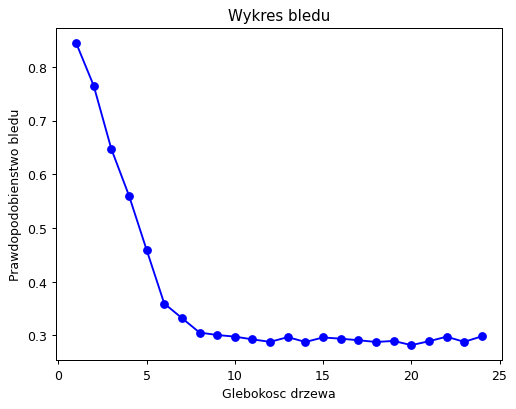

In [11]:
#DRZEWO DECYZYJNE
#Analiza błędy klasyfikacji - dobranie głębokości drzewa do metody drzewa decyzyjnego
data = np.zeros(24)
zakres = [x for x in range(1,25)]
for k in zakres:
    model = tree.DecisionTreeClassifier(max_depth=k)
    model.fit(X_test, y_test.values.ravel())
    predictions = model.predict(X_train)
    data[k-1] = 1-model.score(X_train, y_train)
plt.figure(dpi=90)
plt.plot(zakres, data, '-bo')
plt.title('Wykres bledu')
plt.xlabel('Glebokosc drzewa')
plt.ylabel('Prawdopodobienstwo bledu')

Czas uczenia:  2.682300567626953


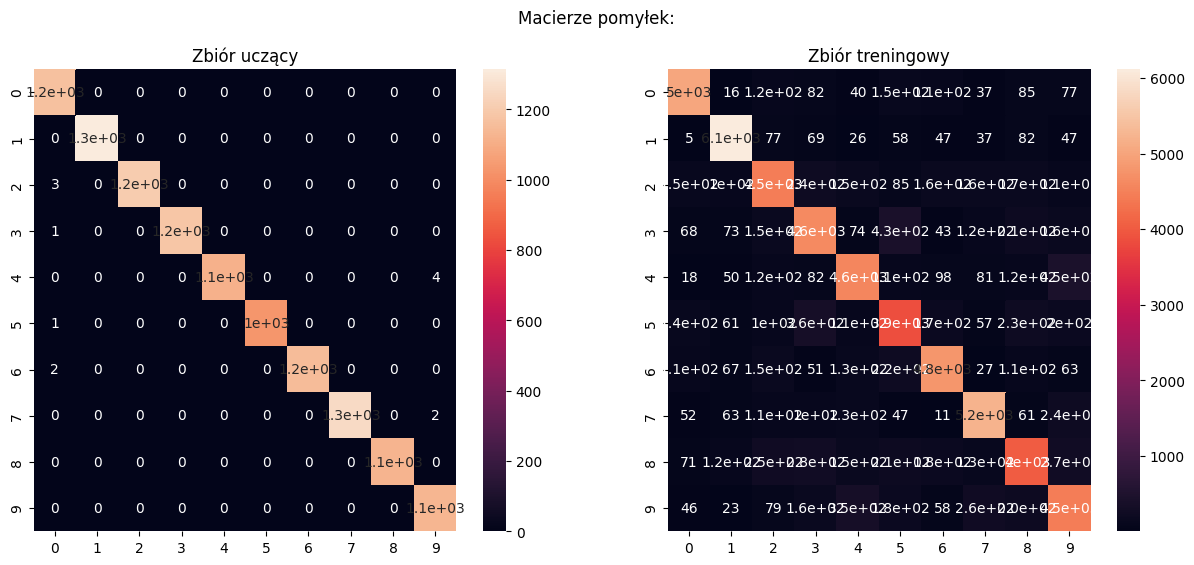

In [25]:
#Klasyfikacja poprzez drzewo decyzyjne
start_time = time.time()
dict = tree.DecisionTreeClassifier(max_depth=20)
dict.fit(X_test, y_test)
end_time = time.time()
print("Czas uczenia: ", end_time - start_time)
wynik_ucz = dict.predict(X_test)
wynik_tren = dict.predict(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Macierze pomyłek:')

#Macierz pomyłek dla zbioru do uczenia
mp = confusion_matrix(y_test, wynik_ucz)
ax1.set_title('Zbiór uczący')
sns.heatmap(mp, annot = True, ax=ax1)

#Macierz pomyłek dla zbioru do trenowania
mp = confusion_matrix(y_train, wynik_tren)
ax2.set_title('Zbiór treningowy')
sns.heatmap(mp, annot = True,ax=ax2)

plt.subplots_adjust(wspace=0.2)
plt.show()


In [26]:
acc = dict.score(X_train, y_train)
print("Precyzja uczenia: ", acc)

#2k danych, precyzja uczenia: 0.5450180072028812
#70k danych, precyzja uczenia: 0.5342136854741897

Precyzja uczenia:  0.8089693020065168


*DO SPRAWOZDANIA:* Po analizie błędu klasyfikacji podjęliśmy decyzję o zastosowaniu drzewa decyzyjnego o głębokości 20. W takim przypadku precyzja uczenia wynosi od 50% w górę (w zależności od wielkości zbioru danych), co jest bardzo niskim wynikiem. Przy analizie macierzy pomyłek widać, że każda cyfra została w znacznej ilości błędnie zinterpetowana. Pomyłki wystąpiły głównie dla cyfr większych od 4.

In [30]:
#METODA SVM
#Analiza błędy klasyfikacji - dobranie odpowiedniej wartości argumentu C
data = np.zeros(24)
cost = [x for x in range(1,25)]
for c in cost:
    model = SVC(C=c)
    model.fit(X_test, y_test.values.ravel())
    predictions = model.predict(X_train)
    data[c-1] = 1-model.score(X_train, y_train)

plt.figure(dpi=90)
plt.plot(cost, data, '-bo')
plt.title('Wykres bledu')
plt.xlabel('Stopien generalizacji C')
plt.ylabel('Prawdopodobienstwo bledu')

#70k danych, czas 1h+, poddałem się


Czas uczenia:  1.8437962532043457


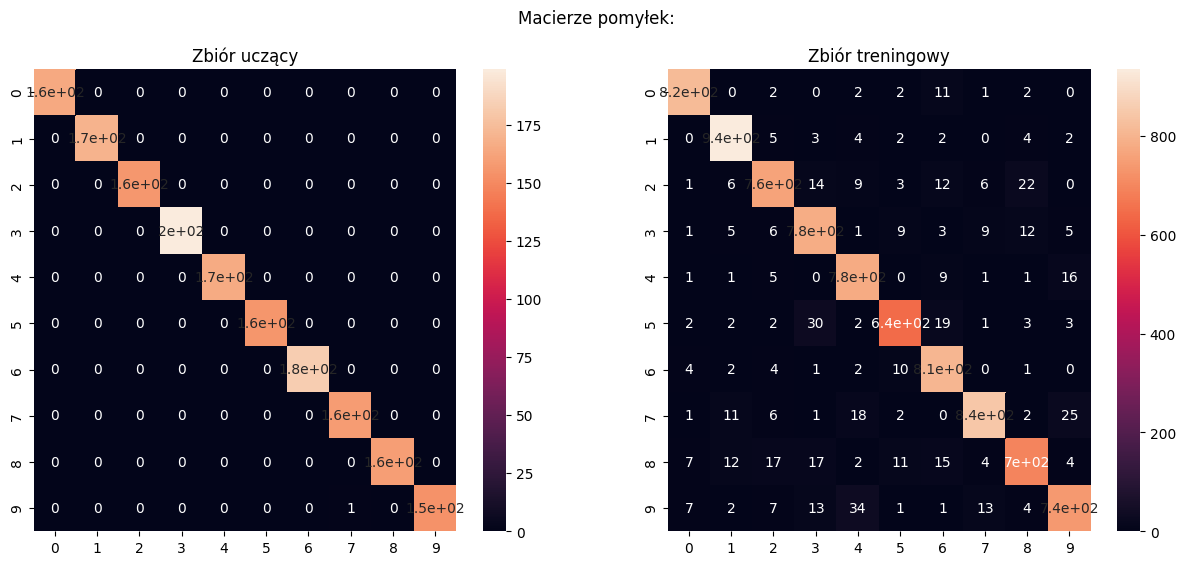

In [11]:
#Klasyfikacja poprzez SVM
start_time = time.time()
svm = SVC(C=4)
svm.fit(X_test, y_test.values.ravel())
end_time = time.time()
print("Czas uczenia: ", end_time - start_time)

wynik_ucz = svm.predict(X_test)
wynik_tren = svm.predict(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Macierze pomyłek:')

#Macierz pomyłek dla zbioru do uczenia
mp = confusion_matrix(y_test, wynik_ucz)
ax1.set_title('Zbiór uczący')
sns.heatmap(mp, annot = True, ax=ax1)

#Macierz pomyłek dla zbioru do trenowania
mp = confusion_matrix(y_train, wynik_tren)
ax2.set_title('Zbiór treningowy')
sns.heatmap(mp, annot = True,ax=ax2)

plt.subplots_adjust(wspace=0.2)
plt.show()

#70k danych:
#czas wykonania całej cell: 5 min 31 sec

In [12]:
acc = svm.score(X_train, y_train)
print("Precyzja uczenia: ", acc)

#2k danych, precyzja uczenia 0.8883553421368547
#70k danych, precyzja uczenia: 0.9705539358600583
#czas wykonania całej cell: 4 min 8 sec
#10k danych po usunięciu zbędnych: 0.9376950780312124
#10k danych bez usunięcia zbędnych: 0.9369747899159664

Precyzja uczenia:  0.9369747899159664


In [148]:
#Pobranie wcześniej wgranej, odręcznie napisanej cyfry, w celu weryfikacji wyników pracy w realnym zastosowaniu
subscription_id = 'd6d8a3e6-525a-4bbe-998a-e7af9e89bd59'
resource_group = 'projektpriad'
workspace_name = 'PRiAD'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='img_7_recznie_przyciete')
dataset.download(target_path='.', overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/extraturboboost/code/Users/01169616/test/img_7_recznie_przyciete.jpg']

In [149]:
#Wybranie sciezki wybranego zdjecia
dane_sciezki = dataset.to_path()
sciezka = dane_sciezki[0]
print(sciezka)

/img_7_recznie_przyciete.jpg


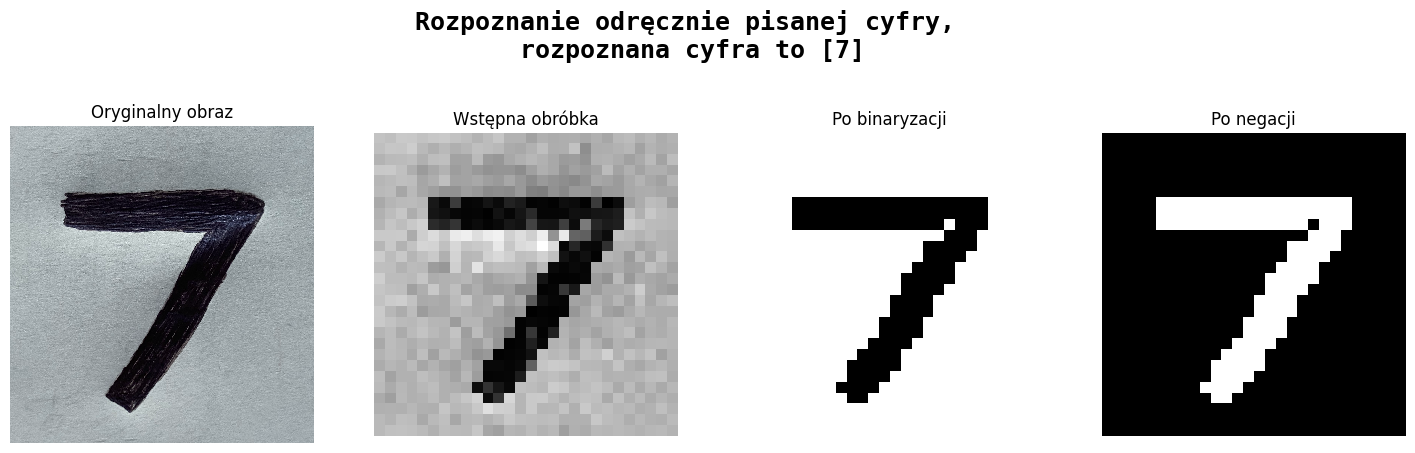

In [167]:
#       Analiza wgranego zdjęcia

#Pobranie
zdjecie = cv2.imread('.'+sciezka)
fig, axs = plt.subplots(1, 4, figsize=(18,5))

axs[0].imshow(zdjecie, interpolation = "none",cmap = "gray")
axs[0].set_title('Oryginalny obraz')
axs[0].axis('off')

#Przejście na skalę szarości
szare_zdjecie = cv2.cvtColor(zdjecie, cv2.COLOR_BGR2GRAY)

#Zmiana rozdzielczości (dopasowanie do zbioru na bazie którego wytrenowaliśmy model)
edytowane_zdjecie = cv2.resize(szare_zdjecie, (28, 28))

#Normalizacja
norm_zdjecie = edytowane_zdjecie / 255.0

axs[1].imshow(edytowane_zdjecie, interpolation = "none",cmap = "gray")
axs[1].set_title('Wstępna obróbka')
axs[1].axis('off')

#Binaryzacja
threshold = threshold_otsu(norm_zdjecie)
binary_image = norm_zdjecie > threshold

axs[2].imshow(binary_image, interpolation = "none",cmap = "gray")
axs[2].set_title('Po binaryzacji')
axs[2].axis('off')

#Negacja
negated_image = ~binary_image

axs[3].imshow(negated_image, interpolation = "none",cmap = "gray")
axs[3].set_title('Po negacji')
axs[3].axis('off')

#Wybór SVM, ponieważ posiada największą precyzję
#Faza klasyfikacji
rozpoznanie = svm.predict(negated_image.reshape(1,784))

plt.suptitle('Rozpoznanie odręcznie pisanej cyfry,\n rozpoznana cyfra to '+ str(rozpoznanie),fontweight='bold',fontsize = 18,family='monospace')
plt.subplots_adjust(top=0.75)
plt.show()


In [68]:
#       Obraz stworzony przy pomocy Paint'a

#Pobranie wcześniej utworzonego obrazu w celu weryfikacji klasyfikacji na danych zewnętrznych
subscription_id = 'd6d8a3e6-525a-4bbe-998a-e7af9e89bd59'
resource_group = 'projektPRiAD'
workspace_name = 'PRiAD'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='img_7_black_background')
dataset.download(target_path='.', overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/extraturboboost/code/Users/01169616/test/img_7_bb.jpg']

In [70]:
#Wybranie sciezki wybranego zdjecia
dane_sciezki = dataset.to_path()
sciezka = dane_sciezki[0]
print(sciezka)

/img_7_bb.jpg


(-0.5, 27.5, 27.5, -0.5)

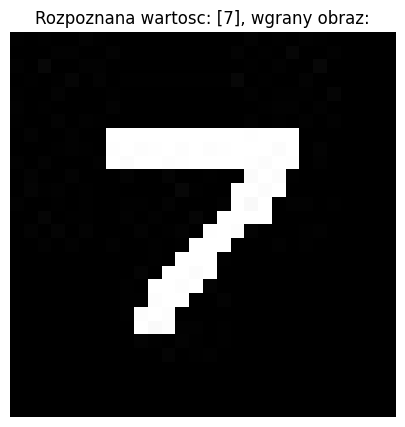

In [80]:
#Pobranie
zdjecie = cv2.imread('.'+sciezka)
fig, axs = plt.subplots(1, 1, figsize=(9,5))

#Przejście na skalę szarości
szare_zdjecie = cv2.cvtColor(zdjecie, cv2.COLOR_BGR2GRAY)

#Zmiana rozdzielczości (dopasowanie do zbioru na bazie którego wytrenowaliśmy model)
edytowane_zdjecie = cv2.resize(szare_zdjecie, (28, 28))

#Normalizacja
norm_zdjecie = edytowane_zdjecie / 255.0

splaszczone_zdjecie = norm_zdjecie.reshape(1, 784)

#Wybór SVM, ponieważ posiada największą precyzję
#Faza klasyfikacji
rozpoznanie = svm.predict(splaszczone_zdjecie)

axs.imshow(zdjecie, interpolation = "none",cmap = "gray")
axs.set_title('Rozpoznana rozpoznanie: '+str(rozpoznanie)+', wgrany obraz:')
axs.axis('off')